# Data Science and Machine Learning Capstone Project
<div style="text-align: right">
 Dan Thompson         </br> 
 danlthom@us.ibm.com  </br>
 August, 2019         </br>
</div>

## Project 4 - Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

 - The data is unlabled. Unlabled data requires clustering, or some other unsupervised algorithm.
 - I'm going to add an outdoor temperature data set, because HEAT problems mainly occur when the temperature is low
 - The Pluto Data can be ignored. I found no correlation of HEAT problems with any PLUTO features. 
 - While there is 10 years of 311 data, just using the last 5 years is good enough to predict the future
 - Yearly data has been split into 5 folds, rather than using randomizers, so I can compare year to year.
 
 [NYC Policy on Heat/Hot Water](https://www1.nyc.gov/site/hpd/owners/heat-hot-water.page)
 
 
Building owners are legally required to provide heat and hot water to their tenants. Hot water must be provided 365 days per year at a constant minimum temperature of 120 degrees Fahrenheit. Heat must be provided between October 1st and May 31st, i.e. "Heat Season," under the following conditions:  

Day  
Between the hours of 6:00am and 10:00pm, if the outside temperature falls below 55 degrees, the inside temperature is required to be at least 68 degrees Fahrenheit.  

Night  
Between the hours of 10:00pm and 6:00am, the inside temperature is required to be at least 62 degrees Fahrenheit.  
 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


In [2]:
#
# Utility Plot Function
#
y_test = [0,0,0]
yhat = [0,0,0]

def plot_results(y_test=y_test,yhat=yhat,title="no title",limit=250):
    
    t = np.arange(0,limit,1)
    plt.figure(figsize=(15,6))

    color = 'tab:red'
    plt.xlabel('Heating Day of Year')
    plt.plot(t, yhat[:limit], color='tab:red')
    plt.plot(t, y_test[:limit], color='tab:blue')
    plt.tick_params(axis='y')
    rmse = np.sqrt(mean_squared_error(y_test,yhat))
    r2 = r2_score(y_test,yhat)
    title = ("%s / R2=%f, RMSE=%f"% (title,r2,rmse))

    plt.title(title)
    plt.show()


In [3]:
# read in the 311 data, already split into folds.
# add Day Of Week
# Drop unneeded columns
df = pd.read_pickle('./files/df_hot.pkl')
df['date_only']=df['created_date'].dt.date
df['DayOfWeek']=df['created_date'].dt.day_name()
df.drop(['complaint_type','address_type','street_name','resolution_description','location_type','status','city'], axis=1, inplace=True)
df.head()

#
# Redefine our Folds based on heating season
#
           # We can throw out fold zero because it is incomplete




,created_date,incident_zip,incident_address,borough,latitude,longitude,DayOfYear,Year,SEQ,Fold,date_only,DayOfWeek
unique_key,,,,,,,,,,,,
43568281,2019-08-16 07:50:14,11216,751 ST MARKS AVENUE,BROOKLYN,40.675098,-73.947870,228,2019,364,2019,2019-08-16,Friday
43561061,2019-08-16 11:51:14,11224,2843 WEST 25 STREET,BROOKLYN,40.577074,-73.992419,228,2019,364,2019,2019-08-16,Friday
43565793,2019-08-16 22:25:58,10452,80 WEST 170 STREET,BRONX,40.840342,-73.922157,228,2019,364,2019,2019-08-16,Friday
43567272,2019-08-16 06:07:17,10031,723 ST NICHOLAS AVENUE,MANHATTAN,40.824803,-73.944212,228,2019,364,2019,2019-08-16,Friday
43563447,2019-08-16 08:45:38,10461,3108 WILKINSON AVENUE,BRONX,40.851653,-73.828635,228,2019,364,2019,2019-08-16,Friday


In [4]:

#
#  reCreate Folds
#

df['HEATING_SEASON']  = 0
df.loc[(df['DayOfYear']<=151 ),'HEATING_SEASON']=1
df.loc[(df['DayOfYear']>=274 ),'HEATING_SEASON']=1

d = 365-274
df['SEQ'] = (df['DayOfYear']+d)%365  # The first day of our fold
df['Fold'] = df['Year']            # The fold number 
df.loc[df['SEQ'] <= d,['Fold']]=df['Year']+1 # The fold number for days between Aug 19 and Dec 31#
#df.Fold.astype(str)
df = df[df['Fold'] > 0]  

In [5]:
df['X'] = df['Fold'] != df['Year']
df[(df['Fold']==2018)&(df['SEQ']==0)].head()

,created_date,incident_zip,incident_address,borough,latitude,longitude,DayOfYear,Year,SEQ,Fold,date_only,DayOfWeek,HEATING_SEASON,X
unique_key,,,,,,,,,,,,,,
37322222,2017-10-01 06:30:23,11223,1628 OCEAN PARKWAY,BROOKLYN,40.608898,-73.967597,274,2017,0,2018,2017-10-01,Sunday,1,True
37322223,2017-10-01 13:47:43,11210,2913 FOSTER AVENUE,BROOKLYN,40.638571,-73.949005,274,2017,0,2018,2017-10-01,Sunday,1,True
37322224,2017-10-01 10:54:46,11210,2620 GLENWOOD ROAD,BROOKLYN,40.633552,-73.951729,274,2017,0,2018,2017-10-01,Sunday,1,True
37322225,2017-10-01 22:36:37,11206,417 LORIMER STREET,BROOKLYN,40.709391,-73.948612,274,2017,0,2018,2017-10-01,Sunday,1,True
37322226,2017-10-01 09:10:40,11204,2270 64 STREET,BROOKLYN,40.613564,-73.979362,274,2017,0,2018,2017-10-01,Sunday,1,True


In [6]:
#
# Group the complaints by day, and also add a rolling average, we might need that later
#

df_daily = pd.DataFrame(df['date_only'])
df_daily['daily_complaints'] = 1;

df_daily['date_only'] = df_daily['date_only'].astype(str)
df_daily = df_daily.groupby(by=['date_only']).sum().reset_index().sort_values(by=['date_only'])
df_daily['complaints_7day_avg'] = df_daily['daily_complaints'].rolling(7, win_type='boxcar').sum()
df_daily['complaints_6day_avg'] = df_daily['daily_complaints'].rolling(6, win_type='boxcar').sum()
df_daily['complaints_5day_avg'] = df_daily['daily_complaints'].rolling(5, win_type='boxcar').sum()
df_daily['complaints_4day_avg'] = df_daily['daily_complaints'].rolling(4, win_type='boxcar').sum()
df_daily['complaints_3day_avg'] = df_daily['daily_complaints'].rolling(3, win_type='boxcar').sum()

df_daily['complaints_7day_avg'] = df_daily['complaints_7day_avg'] - df_daily['daily_complaints']
df_daily['complaints_6day_avg'] = df_daily['complaints_6day_avg'] - df_daily['daily_complaints']
df_daily['complaints_5day_avg'] = df_daily['complaints_5day_avg'] - df_daily['daily_complaints']
df_daily['complaints_4day_avg'] = df_daily['complaints_4day_avg'] - df_daily['daily_complaints']
df_daily['complaints_3day_avg'] = df_daily['complaints_3day_avg'] - df_daily['daily_complaints']

df_daily['complaints_7day_avg'] = df_daily['complaints_7day_avg'] /6
df_daily['complaints_6day_avg'] = df_daily['complaints_6day_avg'] /5
df_daily['complaints_5day_avg'] = df_daily['complaints_5day_avg'] /4
df_daily['complaints_4day_avg'] = df_daily['complaints_4day_avg'] /3
df_daily['complaints_3day_avg'] = df_daily['complaints_3day_avg'] /2






#df_daily.set_index(df_daily['date_only'], inplace=True)
df_daily.drop([0,1,2,3,4,5], inplace=True)
df_daily['date_only'] = pd.to_datetime(df_daily['date_only'])
df_daily['DayOfWeek']=df_daily['date_only'].dt.day_name()
df_daily['DayOfWeek']=df_daily['date_only'].dt.day_name()

df_daily['DayOfYear']=df_daily['date_only'].dt.dayofyear
df_daily['DOY'] = df_daily['date_only'].dt.dayofyear
df_daily['DOW'] = df_daily['date_only'].dt.dayofweek
df_daily['Year']=df_daily['date_only'].dt.year
df_daily['WE']  = 0
df_daily.loc[(df_daily['DOW']==5 )|(df_daily['DOW']==6),'WE']=1
df_daily.loc[(df_daily['DOW']==4 ),'WE']=0.5


df_daily.set_index('date_only',inplace=True)


df_daily['HEATING_SEASON']  = 0
df_daily.loc[(df_daily['DayOfYear']<=151 ),'HEATING_SEASON']=1 #May 31st
df_daily.loc[(df_daily['DayOfYear']>=274 ),'HEATING_SEASON']=1 #Oct 1st (except leap year where we are off by one)

d = 365-274
df_daily['SEQ'] = (df_daily['DayOfYear']+d)%365  # The first day of our fold
df_daily['Fold'] = df_daily['Year']              # The fold number 
df_daily.loc[df_daily['SEQ'] <= d,['Fold']]=df_daily['Year']+1 # The fold number for days between Aug 19 and Dec 31#
#df_daily.Fold.astype(str)
df_daily = df_daily[df_daily['Fold'] > 0]  


In [7]:
df_daily.head(10)

,daily_complaints,complaints_7day_avg,complaints_6day_avg,complaints_5day_avg,complaints_4day_avg,complaints_3day_avg,DayOfWeek,DayOfYear,DOY,DOW,Year,WE,HEATING_SEASON,SEQ,Fold
date_only,,,,,,,,,,,,,,,
2014-08-23,71,73.000000,77.4,76.25,77.333333,74.0,Saturday,235,235,5,2014,1.0,0,326,2014
2014-08-24,48,76.333333,75.2,75.75,73.000000,72.0,Sunday,236,236,6,2014,1.0,0,327,2014
2014-08-25,65,70.666667,70.2,66.75,64.000000,59.5,Monday,237,237,0,2014,0.0,0,328,2014
2014-08-26,65,69.333333,66.4,64.25,61.333333,56.5,Tuesday,238,238,1,2014,0.0,0,329,2014
2014-08-27,62,66.166667,64.4,62.25,59.333333,65.0,Wednesday,239,239,2,2014,0.0,0,330,2014
2014-08-28,94,64.000000,62.2,60.00,64.000000,63.5,Thursday,240,240,3,2014,0.0,0,331,2014
2014-08-29,65,67.500000,66.8,71.50,73.666667,78.0,Friday,241,241,4,2014,0.5,0,332,2014
2014-08-30,64,66.500000,70.2,71.50,73.666667,79.5,Saturday,242,242,5,2014,1.0,0,333,2014
2014-08-31,68,69.166667,70.0,71.25,74.333333,64.5,Sunday,243,243,6,2014,1.0,0,334,2014


boxes [array([ 97.,  97., 889., 889.,  97.])]
whiskers [array([97., 41.]), array([ 889., 2060.])]
caps [array([41., 41.]), array([2060., 2060.])]
medians [array([354., 354.])]


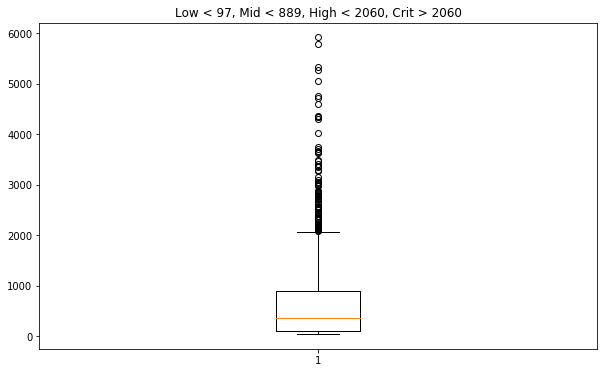

In [8]:
#
# Use a box plot to classify ranges of complaints into low, med, high and critical
#

plt.figure(figsize=(10,6))
B = plt.boxplot(df_daily['daily_complaints'])
B
low   = [item.get_ydata() for item in B['whiskers']][0][0]
med   = [item.get_ydata() for item in B['whiskers']][1][0]
high  = [item.get_ydata() for item in B['whiskers']][1][1]
plt.title("Low < %d, Mid < %d, High < %d, Crit > %d"%(low,med,high,high))

print("boxes",[item.get_ydata() for item in B['boxes']])
print("whiskers",[item.get_ydata() for item in B['whiskers']])
print("caps",[item.get_ydata() for item in B['caps']])
print("medians",[item.get_ydata() for item in B['medians']])

/Users/dtt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Complaints over 5 years with Low=97, Med=889, High=2060')

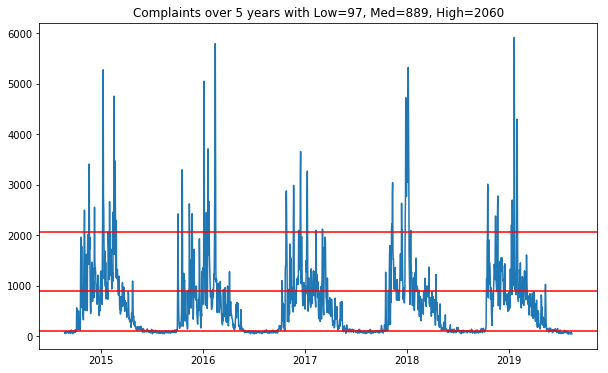

In [9]:
#
# graph the low, medium and high lines so we can see what the distribution of complaints looks like over time
#


plt.figure(figsize=(10,6))
plt.plot(df_daily['daily_complaints'])

#low = 97
#med = 3*low
#high = 2.25*med
plt.axhline(y=low, color='r', linestyle='-')
plt.axhline(y=med, color='r', linestyle='-')
plt.axhline(y=high, color='r', linestyle='-')

plt.title("Complaints over 5 years with Low=%d, Med=%d, High=%d"%(low,med,high))

In [10]:
#
# It's very cyclical, which is as expected
# Let's create a feature called intensity, that indicates the range of calls that day
#



df_daily['intensity']=0
ldays = df_daily[df_daily['daily_complaints']<low].count()[0]
mdays = df_daily[(df_daily['daily_complaints']<med)&(df_daily['daily_complaints']>=low)].count()[0]
hdays = df_daily[(df_daily['daily_complaints']<high)&(df_daily['daily_complaints']>=med)].count()[0]
vdays = df_daily[df_daily['daily_complaints']>=high].count()[0]

print("Number of Low Days %d"% ldays)
print("Number of Med Days %d"% mdays)
print("Number of High Days %d"% hdays)
print("Number of Critical Days %d"% vdays)

df_daily.loc[df_daily['daily_complaints'] >high,'intensity'] = 4
df_daily.loc[df_daily['daily_complaints'] <=high,'intensity'] = 3
df_daily.loc[df_daily['daily_complaints'] <=med,'intensity'] = 2
df_daily.loc[df_daily['daily_complaints'] <=low,'intensity'] = 1

df_daily.head()

Number of Low Days 450
Number of Med Days 912
Number of High Days 373
Number of Critical Days 83


,daily_complaints,complaints_7day_avg,complaints_6day_avg,complaints_5day_avg,complaints_4day_avg,complaints_3day_avg,DayOfWeek,DayOfYear,DOY,DOW,Year,WE,HEATING_SEASON,SEQ,Fold,intensity
date_only,,,,,,,,,,,,,,,,
2014-08-23,71,73.000000,77.4,76.25,77.333333,74.0,Saturday,235,235,5,2014,1.0,0,326,2014,1
2014-08-24,48,76.333333,75.2,75.75,73.000000,72.0,Sunday,236,236,6,2014,1.0,0,327,2014,1
2014-08-25,65,70.666667,70.2,66.75,64.000000,59.5,Monday,237,237,0,2014,0.0,0,328,2014,1
2014-08-26,65,69.333333,66.4,64.25,61.333333,56.5,Tuesday,238,238,1,2014,0.0,0,329,2014,1
2014-08-27,62,66.166667,64.4,62.25,59.333333,65.0,Wednesday,239,239,2,2014,0.0,0,330,2014,1


### Join the daily data with daily temperature lows

In [11]:
#
# Pull in historical weather data, comprised of min temps, Also wrangled the historical average temp
# Create a new feature based on the 5 day average temperature
# Join it with 311 data
#

df_temperature = pd.read_csv('./files/JFK_temps_plus_avg.csv', index_col=0, parse_dates=[0], usecols=[0,3,4,5]).reset_index()
df_temperature['date_only']=df_temperature['DATE'].dt.date
df_temperature.set_index(df_temperature['date_only'], inplace=True)
df_temperature['TMIN_5day_avg'] = df_temperature['TMIN'].rolling(5,win_type='boxcar').mean()
df_temperature['TDIFF'] = df_temperature['TMIN']-df_temperature['HAVG']


In [12]:
#
# Also, join the daily call data with the temperature data
#

df_daily = df_daily.join(df_temperature, how="inner", rsuffix="_R")
df_daily['InvTMP'] = 100-df_daily['TMIN']

df_daily.drop('DATE', axis=1, inplace=True)




Text(0.5, 1.0, 'Complaints over 5 years with Low=97, Med=889, High=2060 - Heating season in green')

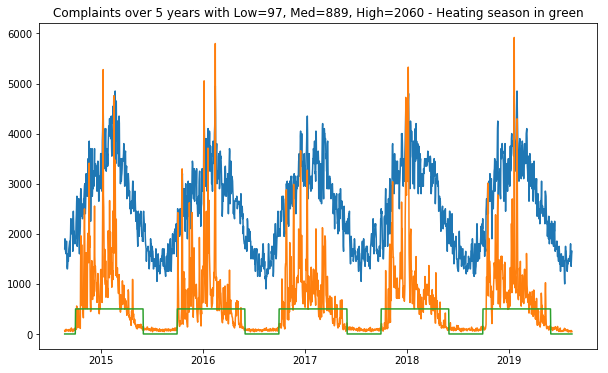

In [13]:
#
# So this is a little odd, but it's an interesting plot
# Invert the temperature data so its cycle matches the complaint cycle
# Also plot the heating season. 
# Then scale everthing so it fits
#

plt.figure(figsize=(10,6))
plt.plot(df_daily['InvTMP']*50)
plt.plot(df_daily['daily_complaints'])
plt.plot(df_daily['HEATING_SEASON']*500)

i = 0
x=2015


plt.title("Complaints over 5 years with Low=%d, Med=%d, High=%d - Heating season in green"%(low,med,high))

Text(0.5, 1.0, 'Complaints in 2018 season compared to difference in temp against average')

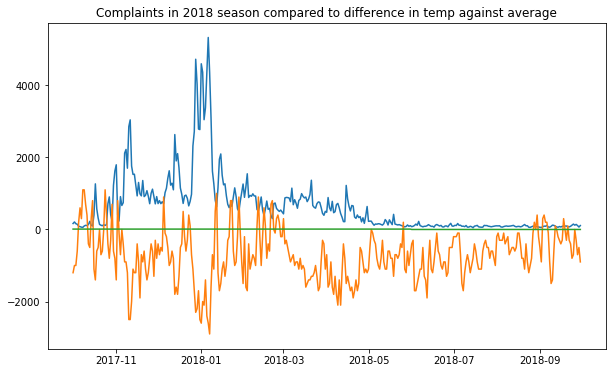

In [14]:
#
# So this is a little odd, but it's an interesting plot
# Invert the temperature data so its cycle matches the complaint cycle
# Also plot the heating season. 
# Then scale everthing so it fits
#

plt.figure(figsize=(10,6))
plt.plot(df_daily[df_daily['Fold']==2018]['daily_complaints'])
plt.plot(df_daily[df_daily['Fold']==2018]['TDIFF']*100)
plt.plot(df_daily[df_daily['Fold']==2018]['HEATING_SEASON']*10)

i = 0
x=2015


plt.title("Complaints in 2018 season compared to difference in temp against average")

### What those graphs show

There are some interesting things going on here. First off, when the heating season ends, we still get some calls. That's because hot water calls that apply regardless of heating season.

Calls drop dramatically after March 21st.  Why are there so many calls at the start of heating season? Why do they drop off after the weather seems to start to warm, i.e. past peak cold? Most of the complaints are to the right of March 21st!  Why?


## Now we'll count

starts at 5:00AM, dip mid-afternoon, bump at 10:00PM


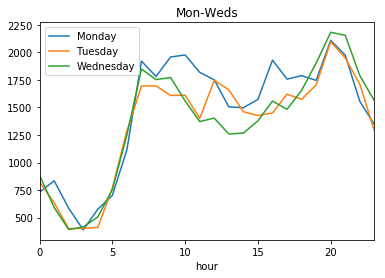

In [15]:
df_1 = df[(df['Fold']==2019)][['created_date','DayOfWeek']]

df_1['hour'] = df_1['created_date'].dt.hour
df_1.drop(['created_date'],axis=1,inplace=True)
df_1 = pd.get_dummies(df_1['DayOfWeek']).join(df_1)

df_1.groupby(by="hour").sum()[['Monday','Tuesday','Wednesday']].plot()
plt.title("Mon-Weds")
print ("starts at 5:00AM, dip mid-afternoon, bump at 10:00PM")




starts at 7:00AM, dip at mid-afternoon, no bump at 10:00PM


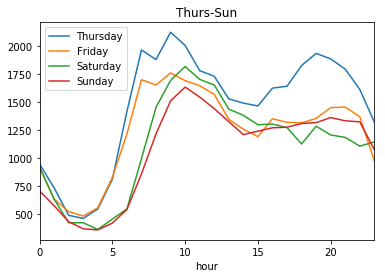

In [16]:
df_1.groupby(by="hour").sum()[['Thursday','Friday','Saturday','Sunday']].plot()
plt.title("Thurs-Sun")
print ("starts at 7:00AM, dip at mid-afternoon, no bump at 10:00PM")

### What these graphs show
 - Monday-Friday people tend to wake up and report problems starting around 6:00 AM
 - Saturday-Sunday people tend to sleep in and not report problems until later
 - On weekdays there is a second peak around 10:00PM
 - On weekends, including Friday night, there is no second peak.
 
The rules:  
Day  
Between the hours of 6:00am and 10:00pm, if the outside temperature falls below 55 degrees, the inside temperature is required to be at least 68 degrees Fahrenheit.  

Night  
Between the hours of 10:00pm and 6:00am, the inside temperature is required to be at least 62 degrees Fahrenheit.

## Now plot the average number of calls by temperature

There are 26 percent fewer calls on Sunday than the peak


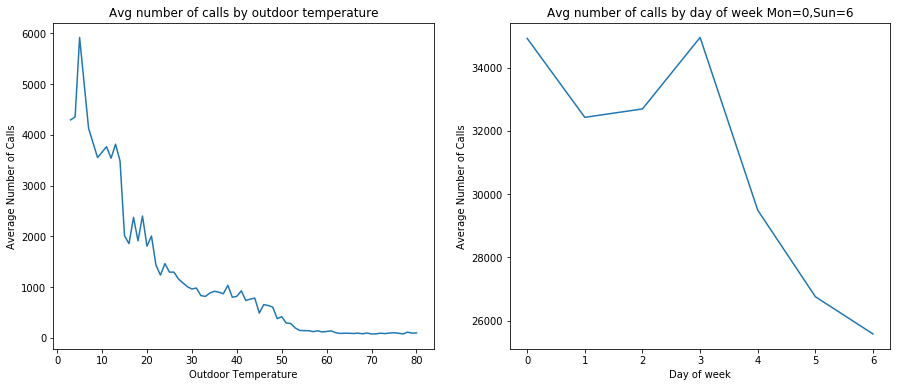

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

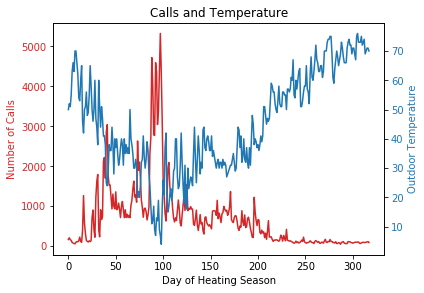

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

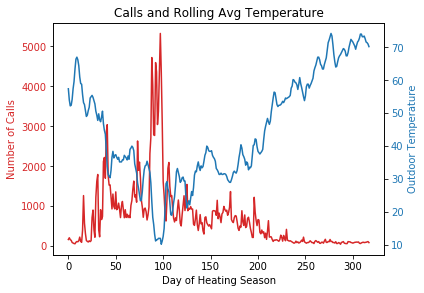

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

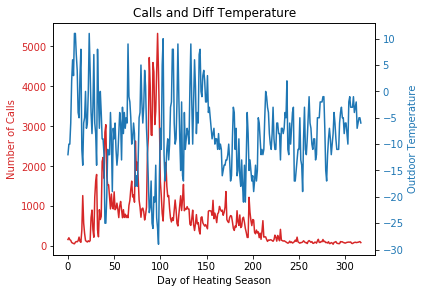

In [17]:

plt.figure(figsize=(15,6))
plt.subplot(121)

df_daily['count']=1


df_daily_temp_plan = df_daily[(df_daily['Fold']>=2017)][['TMIN','daily_complaints']].groupby('TMIN').mean()
plt.plot(df_daily_temp_plan)
plt.title("Avg number of calls by outdoor temperature")
plt.xlabel('Outdoor Temperature')
plt.ylabel('Average Number of Calls')

plt.subplot(122)
df_daily['count']=1
df_daily_temp_plan = df_daily[(df_daily['Fold']>=2019)][['DOW','daily_complaints']].groupby(['DOW']).sum()
plt.plot(df_daily_temp_plan)
plt.title("Avg number of calls by day of week Mon=0,Sun=6")
plt.xlabel('Day of week')
plt.ylabel('Average Number of Calls')

n =  (100-(np.array(df_daily_temp_plan.min()*100)[0]/np.array(df_daily_temp_plan.max())[0]))


print("There are %d percent fewer calls on Sunday than the peak" % n)
def plot_by_year(year, how, title, limit=318):
    #plt.subplot(122)
    plt.figure(figsize=(15,6))
    df_daily['count']=1
    data1 = (df_daily[(df_daily['Fold']==year)][['daily_complaints']])
    data2 = (df_daily[(df_daily['Fold']==year)][[how]])
    data3 = df_daily[(df_daily['Fold']==year)]['HEATING_SEASON']
    #plt.title("311 calls by day of year")
    t = np.arange(0,limit,1)

    plt.figure(figsize=(15,6))
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Day of Heating Season')
    ax1.set_ylabel('Number of Calls', color=color)
    ax1.plot(t, data1[:limit], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Outdoor Temperature', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, data2[:limit], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
#    ax2.plot(t, data3[:limit], color='tab:green')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.show()

plot_by_year(2018,'TMIN', 'Calls and Temperature')
plot_by_year(2018,'TMIN_5day_avg','Calls and Rolling Avg Temperature')
plot_by_year(2018,'TDIFF', 'Calls and Diff Temperature')

#plot_by_year(2017)
#plot_by_year(2016)
#plot_by_year(2015)



On average 90 calls per day out of heating season


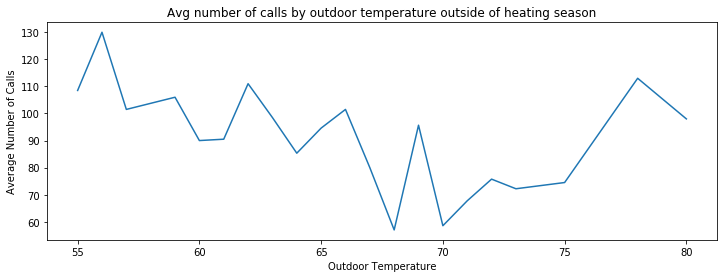

In [18]:
plt.figure(figsize=(12,4))

df_temp_plan = df_daily[(df_daily['Fold']==2019)&(df_daily['HEATING_SEASON']==0)][['TMIN','daily_complaints']].groupby('TMIN').mean()
plt.plot(df_temp_plan)
plt.title("Avg number of calls by outdoor temperature outside of heating season")
plt.xlabel('Outdoor Temperature')
plt.ylabel('Average Number of Calls')

print ("On average %d calls per day out of heating season"% df_temp_plan.values.mean())


### What this tells us 
 - There are 20-25% fewer calls on weekends
 - Calls spike when the temperature dips
 - They begin to pick up in the fall at the start of heating season
 - Even though there temperature spikes in late winter, the number of calls declines for those later spikes
 - It looks like the number of calls is related to steep downward changes in temperature.
 - During Not-Heating season, there are still a number of calls related to hot water. This indicates a non-linearity in our model. 
 - 88 calls on average per day is a baseline regardless of temperature
 
 
### I think what we should do is this
 - Just use time series data showing total calls per day, well, we kind of have that
 - What about a running average of calls for the last week? Are they a good predictor of calls going forward?
 - There are two related factors, which is day of year, and temperature
 - 
 - We already have a pretty good break down of calls per hour by day
 - 


In [19]:
df_daily.columns

Index(['daily_complaints', 'complaints_7day_avg', 'complaints_6day_avg',
       'complaints_5day_avg', 'complaints_4day_avg', 'complaints_3day_avg',
       'DayOfWeek', 'DayOfYear', 'DOY', 'DOW', 'Year', 'WE', 'HEATING_SEASON',
       'SEQ', 'Fold', 'intensity', 'TMIN', 'SEQ_R', 'HAVG', 'date_only',
       'TMIN_5day_avg', 'TDIFF', 'InvTMP', 'count'],
      dtype='object')

(318, 1)

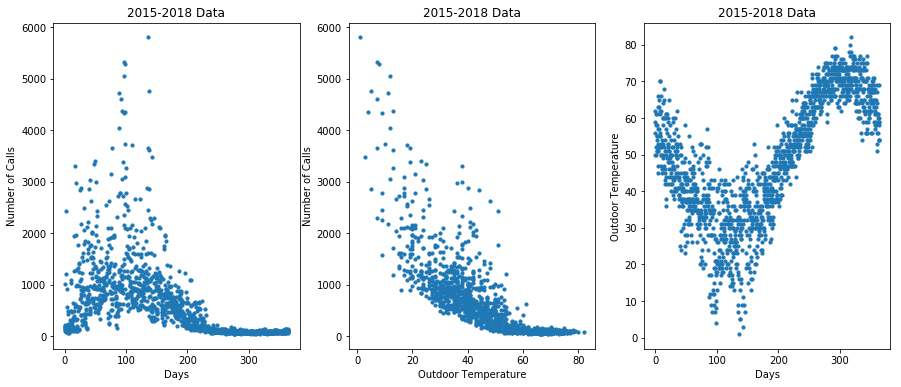

In [20]:
from sklearn.preprocessing import PolynomialFeatures

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

df_daily['DayOfSeason']= (df_daily['SEQ']/1).astype('int')

x_features = ['DayOfSeason','TMIN','DOW']
y_features = ['daily_complaints']
features = x_features+y_features


data1 = df_daily[df_daily['Fold'].isin([2015,2016,2017,2018])][features]
X_Train = data1[x_features]
y_train = data1[y_features]       

data2 = df_daily[df_daily['Fold'].isin([2019])][features]
X_Test = data2[x_features]
y_test = data2[y_features]       

title = "2015-2018 Data"

plt.figure(figsize=(15,6))
#    print(i,data[['TMIN']].shape,data[['daily_complaints']].shape)    
plt.subplot(1,3,1)
plt.scatter(X_Train['DayOfSeason'], y_train, s=10 )
plt.title(title)
plt.xlabel('Days')
plt.ylabel('Number of Calls')

plt.subplot(1,3,2)
plt.scatter(X_Train['TMIN'], y_train, s=10 )
plt.title(title)
plt.xlabel('Outdoor Temperature')
plt.ylabel('Number of Calls')

plt.subplot(1,3,3)
plt.scatter(X_Train['DayOfSeason'], X_Train['TMIN'], s=10 )
plt.title(title)
plt.ylabel('Outdoor Temperature')
plt.xlabel('Days')
    
y_test.shape

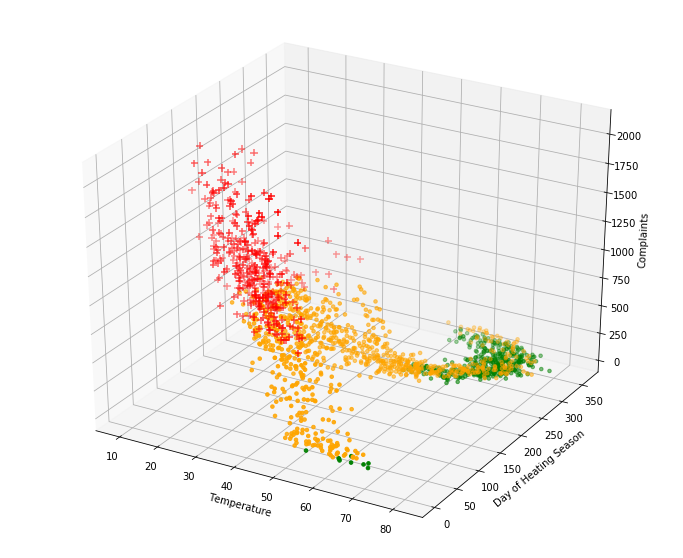

In [21]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

n = 100
ms = ["o",".",".","+"]
colors = ['blue','green','orange','red',]

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for i in range (1, 4):
    
    data = df_daily[(df_daily['intensity']==i)&(df_daily['Fold'].isin([2015,2016,2017,2018,2019]))][features]
    X = data[x_features]
    y = data[y_features]
    m = ms[i]
    ax.scatter( np.array(X['TMIN'])[::1],np.array(X['DayOfSeason'])[::1], np.array(y)[::1], marker=m, s=50, color=colors[i])

ax.set_ylabel('Day of Heating Season')
ax.set_xlabel('Temperature')
ax.set_zlabel('Complaints')

plt.show()

## Do a polynomial regression against features and number of calls
 - This will give us our first model to predict number of calls for heating issues

In [22]:
best_r = 0
best_k = 1

#X_Train = scaler.fit_transform(X_Train)
#X_Test  = scaler.fit_transform(X_Test)

for k in range(1,11):
    polynomial_features= PolynomialFeatures(degree=k)
    x_poly = polynomial_features.fit_transform(X_Train)

    model = LinearRegression()
    model.fit(x_poly, y_train)
      
    tot_k = 0

    y_poly_pred = model.predict(polynomial_features.fit_transform(X_Test))

    rmse = np.sqrt(mean_squared_error(y_test,y_poly_pred))
    r2 = r2_score(y_test,y_poly_pred)
    tot_k += r2

    if (tot_k > best_r):
        best_r = tot_k
        best_k = k
        
# Now that we've found the best K, let's plot all the temperatures as a sanity check
polynomial_features= PolynomialFeatures(degree=best_k)
x_poly = polynomial_features.fit_transform(X_Train)
model = LinearRegression()
model.fit(x_poly, y_train)
y_poly_pred = model.predict(polynomial_features.fit_transform(X_Test))
rmse = np.sqrt(mean_squared_error(y_test,y_poly_pred))
r2 = r2_score(y_test,y_poly_pred)
print("Best K=%d, R2=%f, RMSE=%f"% (best_k,r2,rmse))
#print("LR Coefficients:",model.coef_)
#print("LR Intercept:",model.intercept_)
print("----")



Best K=6, R2=0.824105, RMSE=290.997241
----


### A polynomial of degree 6 seems to give the most consistent R value for features, including Outdoor Temperature, vs number of daily calls.

This should meet the requirement of a prediction model. But let's try some other things as well.

<Figure size 864x432 with 0 Axes>

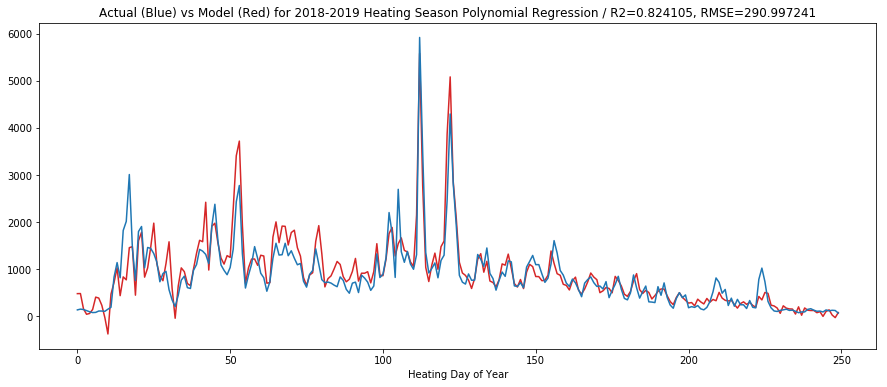

In [24]:
from sklearn.metrics import mean_squared_error

year=2019
title_template = 'Actual (Blue) vs Model (Red) for %d-%d Heating Season %s'
title = title_template%(year-1,year, "Polynomial Regression")
#t = np.arange(0,limit,1)

plt.figure(figsize=(12,6))

plot_results(y_test,y_poly_pred,title)



## First Results
 - 311 Heat related calls are related to the outdoor temperature as shown over a five year period. The results are consistent with an R score as high as .90

## Let's run some regressions

Feature importances
1. feature 1 TMIN (0.797061)
2. feature 0 DayOfSeason (0.173733)
3. feature 2 DOW (0.029205)


/Users/dtt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/dtt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


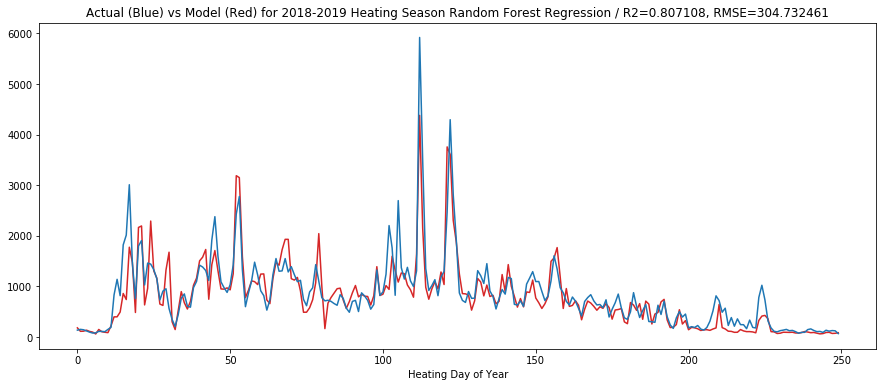

In [26]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr


scaler = StandardScaler(copy=True, with_mean=False, with_std=True)

X_Train_tx = scaler.fit_transform(X_Train)
X_Test_tx = scaler.fit_transform(X_Test)

regr = RandomForestRegressor()
regr.fit(X_Train_tx, y_train)  
yhat = regr.predict(X_Test_tx)

importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
labels = features
title = title_template%(year-1,year, "Random Forest Regression")

print ("Feature importances")
for f in range(X_Train.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1,  indices[f], labels[indices[f]], importances[indices[f]]))

plot_results(y_test,yhat,title)

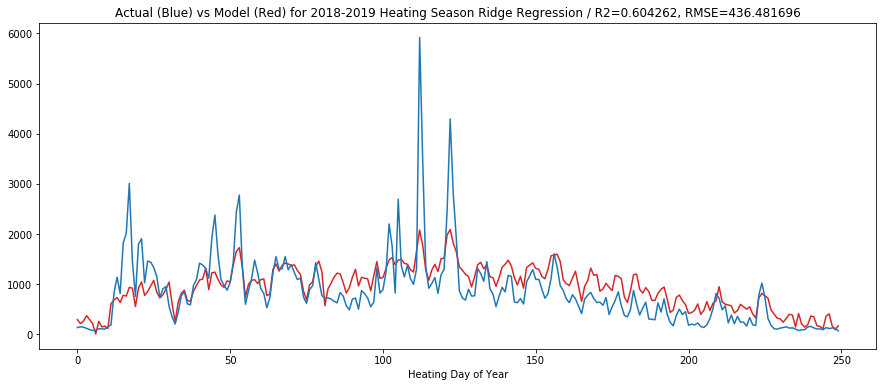

In [27]:
from sklearn.linear_model import Ridge 

scaler = StandardScaler(copy=True, with_mean=False, with_std=False)

X_Train_tx = scaler.fit_transform(X_Train)
X_Test_tx = scaler.fit_transform(X_Test)

regr = Ridge()
regr.fit(X_Train_tx, y_train)  
yhat = regr.predict(X_Test_tx)

title = title_template%(year-1,year,"Ridge Regression")

plot_results(y_test,yhat,title)

## 2nd Results
 - This shows that the ResArea of a building is the best indicator that it will generate HEAT related 311 calls
 - But that outdoor temperature is also a major factor in generating these calls
 - Repeated for five years worth of data
 

# Conclusions

Overall results showed a positive correlation between outdoor temperature and 311 calls related to HEAT or HEAT/HOT WATER. The colder the temperatures the more daily calls are be generated.  

In addition, it was shown that the Residential Area of a building is the most important factor in determining whether it will generate these types of 311 calls.  While Age of the building and the number of floors in the building had little relevance.

Data used included information from the 311 database, the PLUTO database, and NYC Weather data from NOAA.
 - 311 data included at least 10 years of information. I decided to use only the last 5 years, as this seemed most relevent to predicting future calls.
 - 311 data was split into five individual folds of 364 days each. These were used as separate test and training in order to validate assumptions for prior years.
 - Only the minimum temperature for the day was considered as a measure as it seemed like the coldest parts of the coldest days would generate the most calls. Further study of daytime temperatures in relation to the distribution of calls throughout the day would require futher study.

Methods used included visualization to verify that the data were indeed useful, and that the assumptions were correct. Some methods led to dead ends, such as several attempts at classificating zipcodes. These sideline studies were kept in this notebook for possible further development later on.

Polynomial Regression was used to model temperature data. An 8th degree polynomial fit the data with an average R score of 80 when tested across five individual years. Random Forest Classification was used to model building data, and showed that certain features of the building were important in predicting whether it would generate these types of 311 calls. Naive Bayes was used for with the same parameters as RFC, and showed between 60% and 75% accuracy that a given building would generate 311 calls on a given day, which are very good results. Or at least better than guessing.

In addtion to these techniques I used correlation to show that some variables were good proxies for others. For example, ResArea and BuiltArea tracked at 0.99, and therefore one could be removed from the feature set. This is an example of feature reduction.

For feature creation, I added the daily temperature data, but I also built aggregates of call counts vs temperature, and for the daily tallies.  I also created five folds in the data in order to cross validate my assumptions.

Other insights - It is important to note that on median each zipcode only produces 3 complaints annually. Therefore it is crucial to stay on top of the highest call generating zipcodes, which I have documented in this study. 


Daniel Thompson  
danlthom@us.ibm.com  
August 2019  


